# Exploratory Data Analysis

## Dataset Overview

The Lizard Dataset contains image regions extracted from colon whole-slide images at 20x objective magnification, along with comprehensive annotations for nuclear instance segmentation and classification.

**Task**: Nuclear instance segmentation and classification

### Nuclear Categories:
Class 1: Neutrophil<br>
Class 2: Epithelial<br>
Class 3: Lymphocyte<br>
Class 4: Plasma<br>
Class 5: Eosinophil<br>
Class 6: Connective tissue<br>

### Label Structure:
Each label file (.mat format) contains:
- inst_map: Instance segmentation map (H x W)
- class: Nuclear category for each nucleus (N x 1)
- bbox: Bounding box coordinates (N x 4) in format (y1, y2, x1, x2)
- centroid: Centroid coordinates (N x 2) in format (x, y)
- id: Nucleus ID mapping array (N x 1)

In [55]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import scipy.io as sio
from collections import Counter
import warnings
from tqdm import tqdm

warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

In [56]:
BASE_PATH = '../data'

IMAGES_PATH_1 = os.path.join(BASE_PATH, 'lizard_images1', 'Lizard_Images1')
IMAGES_PATH_2 = os.path.join(BASE_PATH, 'lizard_images2', 'Lizard_Images2')
LABELS_PATH = os.path.join(BASE_PATH, 'lizard_labels', 'Lizard_Labels', 'Labels')
OVERLAY_PATH = os.path.join(BASE_PATH, 'overlay', 'Overlay')
INFO_CSV_PATH = os.path.join(BASE_PATH, 'lizard_labels', 'Lizard_Labels', 'info.csv')

CLASS_NAMES = {
    1: 'Neutrophil',
    2: 'Epithelial',
    3: 'Lymphocyte',
    4: 'Plasma',
    5: 'Eosinophil',
    6: 'Connective Tissue'
}

CLASS_COLORS = {
    1: '#FF6B6B',  # Red - Neutrophil
    2: '#4ECDC4',  # Teal - Epithelial
    3: '#45B7D1',  # Blue - Lymphocyte
    4: '#FFA07A',  # Orange - Plasma
    5: '#98D8C8',  # Green - Eosinophil
    6: '#F7DC6F'   # Yellow - Connective Tissue
}

In [57]:
info_df = pd.read_csv(INFO_CSV_PATH)
print("Dataset Information Shape:", info_df.shape)
info_df.head()

Dataset Information Shape: (238, 3)


,Filename,Source,Split
0,dpath_1,1800127001_2019-04-30 10_40_02-lv1-1001-22444-...,3
1,dpath_2,1902160001_2019-06-11 12_36_32-lv1-39045-16016...,2
2,dpath_3,2019_03867_1-1_2019-02-20 20_00_32-lv1-35269-3...,3
3,dpath_4,2019-07501-1-1-1_2019-05-29 08_22_25-lv1-9661-...,1
4,dpath_5,2018_83220_1-1_2019-02-20 18_33_11-lv1-58151-3...,2


### Distribution of data by source and split

In [58]:
print(f"Total number of images: {len(info_df)}")
print(f"\nData splits distribution:")
print(info_df['Split'].value_counts().sort_index())
print(f"\nSource distribution:")
info_df['Source_Prefix'] = info_df['Filename'].str.split('_').str[0]
print(info_df['Source_Prefix'].value_counts())

Total number of images: 238

Data splits distribution:
Split
1    70
2    70
3    98
Name: count, dtype: int64

Source distribution:
Source_Prefix
dpath      69
crag       64
glas       61
pannuke    28
consep     16
Name: count, dtype: int64


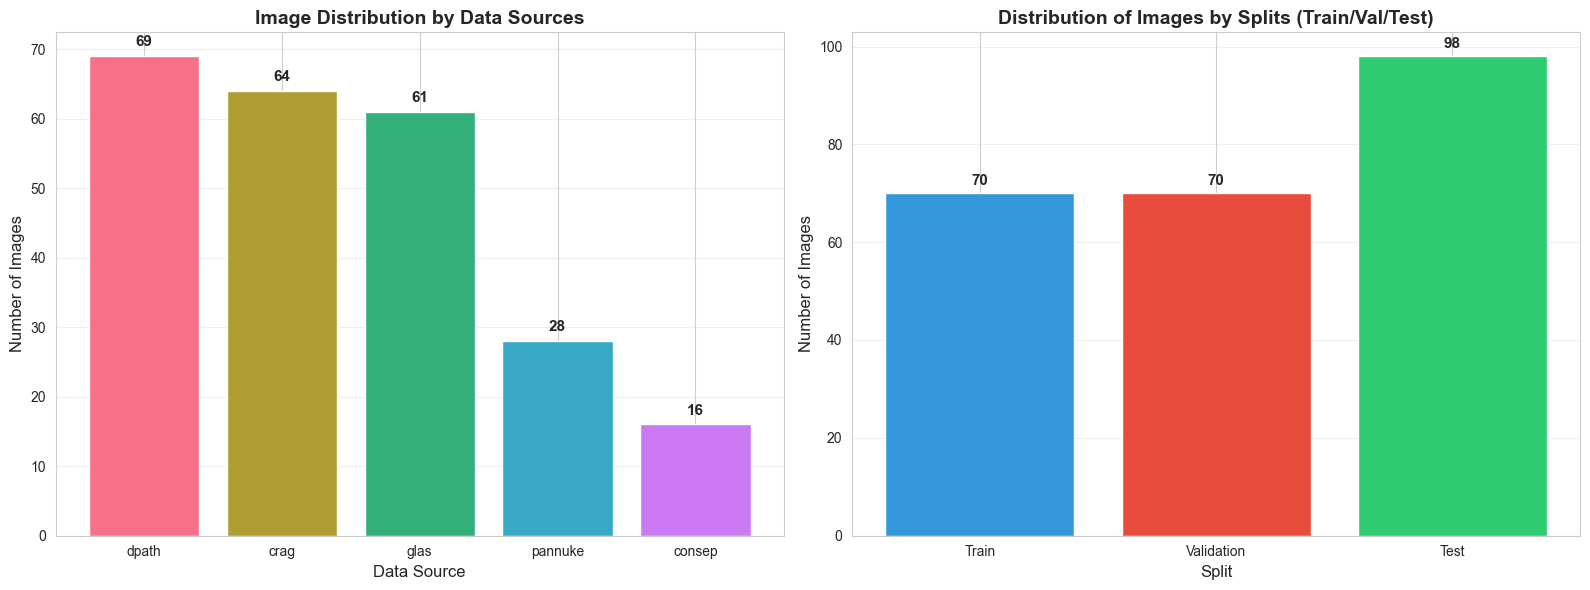


Detailed statistics by data sources:
source_prefix
dpath      69
crag       64
glas       61
pannuke    28
consep     16
Name: count, dtype: int64

Split statistics:
Train: 70 (29.4%)
Validation: 70 (29.4%)
Test: 98 (41.2%)


In [59]:
info_df['source_prefix'] = info_df['Filename'].str.split('_').str[0]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

source_counts = info_df['source_prefix'].value_counts()
axes[0].bar(source_counts.index, source_counts.values, color=sns.color_palette("husl", len(source_counts)))
axes[0].set_xlabel('Data Source', fontsize=12)
axes[0].set_ylabel('Number of Images', fontsize=12)
axes[0].set_title('Image Distribution by Data Sources', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

for i, (source, count) in enumerate(source_counts.items()):
    axes[0].text(i, count + 1, str(count), ha='center', va='bottom', fontsize=11, fontweight='bold')

split_counts = info_df['Split'].value_counts().sort_index()
split_labels = ['Train', 'Validation', 'Test']
colors_split = ['#3498db', '#e74c3c', '#2ecc71']
axes[1].bar(split_labels, split_counts.values, color=colors_split)
axes[1].set_xlabel('Split', fontsize=12)
axes[1].set_ylabel('Number of Images', fontsize=12)
axes[1].set_title('Distribution of Images by Splits (Train/Val/Test)', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

for i, count in enumerate(split_counts.values):
    axes[1].text(i, count + 1, str(count), ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nDetailed statistics by data sources:")
print(source_counts)
print(f"\nSplit statistics:")
for split, label in zip([1, 2, 3], split_labels):
    count = (info_df['Split'] == split).sum()
    percentage = (count / len(info_df)) * 100
    print(f"{label}: {count} ({percentage:.1f}%)")



Distribution of sources across splits:


,Train,Validation,Test,Total
source_prefix,,,,
consep,0,0,16,16
crag,21,25,18,64
dpath,20,25,24,69
glas,29,20,12,61
pannuke,0,0,28,28
All,70,70,98,238


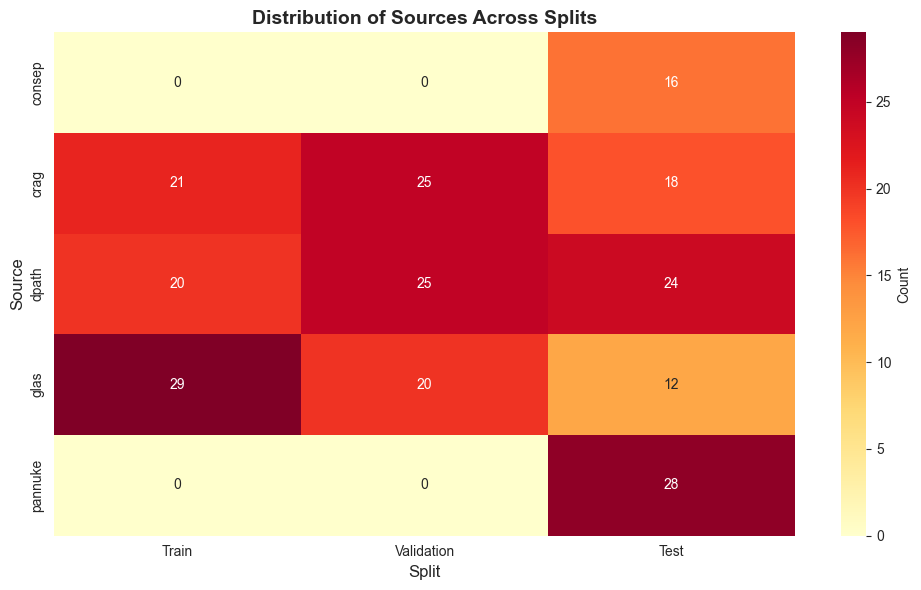

In [60]:
crosstab = pd.crosstab(info_df['source_prefix'], info_df['Split'], margins=True)
crosstab.columns = ['Train', 'Validation', 'Test', 'Total']

print("\nDistribution of sources across splits:")
display(crosstab)

plt.figure(figsize=(10, 6))
crosstab_viz = pd.crosstab(info_df['source_prefix'], info_df['Split'])
crosstab_viz.columns = ['Train', 'Validation', 'Test']
sns.heatmap(crosstab_viz, annot=True, fmt='d', cmap='YlOrRd', cbar_kws={'label': 'Count'})
plt.title('Distribution of Sources Across Splits', fontsize=14, fontweight='bold')
plt.xlabel('Split', fontsize=12)
plt.ylabel('Source', fontsize=12)
plt.tight_layout()
plt.show()

### Collecting statistics on all labels

In [ ]:
def load_label(label_path):
    try:
        label = sio.loadmat(label_path)
        return {
            'inst_map': label['inst_map'],
            'id': label['id'],
            'class': label['class'],
            'bbox': label['bbox'],
            'centroid': label['centroid']
        }
    except Exception as e:
        print(f"Error loading {label_path}: {e}")
        return None

def get_nuclei_stats(label_data):
    classes = label_data['class'].flatten()
    nuclei_ids = label_data['id'].flatten()
    inst_map = label_data['inst_map']
    bboxes = label_data['bbox']

    class_counts = Counter(classes)

    areas = []
    for nuc_id in nuclei_ids:
        area = np.sum(inst_map == nuc_id)
        areas.append(area)

    bbox_widths = bboxes[:, 3] - bboxes[:, 2]  
    bbox_heights = bboxes[:, 1] - bboxes[:, 0]  

    return {
        'total_nuclei': len(classes),
        'class_counts': class_counts,
        'areas': areas,
        'classes': classes,
        'bbox_widths': bbox_widths,
        'bbox_heights': bbox_heights
    }

def load_image(filename, images_path_1, images_path_2):
    img_path = os.path.join(images_path_1, filename)
    if os.path.exists(img_path):
        return np.array(Image.open(img_path))

    img_path = os.path.join(images_path_2, filename)
    if os.path.exists(img_path):
        return np.array(Image.open(img_path))

    return None


In [ ]:
label_files = sorted([f for f in os.listdir(LABELS_PATH) if f.endswith('.mat')])

print(f"Found labels: {len(label_files)}")

all_stats = []
global_class_counts = Counter()
all_areas = []
all_classes_list = []

print("\nCollecting statistics for all labels...")
for label_file in tqdm(label_files):
    label_path = os.path.join(LABELS_PATH, label_file)
    label_data = load_label(label_path)

    if label_data is not None:
        stats = get_nuclei_stats(label_data)
        stats['filename'] = label_file.replace('.mat', '')
        all_stats.append(stats)

        global_class_counts.update(stats['class_counts'])
        all_areas.extend(stats['areas'])  
        all_classes_list.extend(stats['classes'])

print(f"Total nuclei in dataset: {sum(global_class_counts.values())}")

Found labels: 238



100%|██████████| 238/238 [21:17<00:00,  5.37s/it] 

Total nuclei in dataset: 431913


### Class distribution analysis


Detailed class statistics:
Neutrophil          :  4,116 ( 0.95%)
Epithelial          : 210,372 (48.71%)
Lymphocyte          : 92,238 (21.36%)
Plasma              : 24,861 ( 5.76%)
Eosinophil          :  2,979 ( 0.69%)
Connective Tissue   : 97,347 (22.54%)
TOTAL               : 431,913


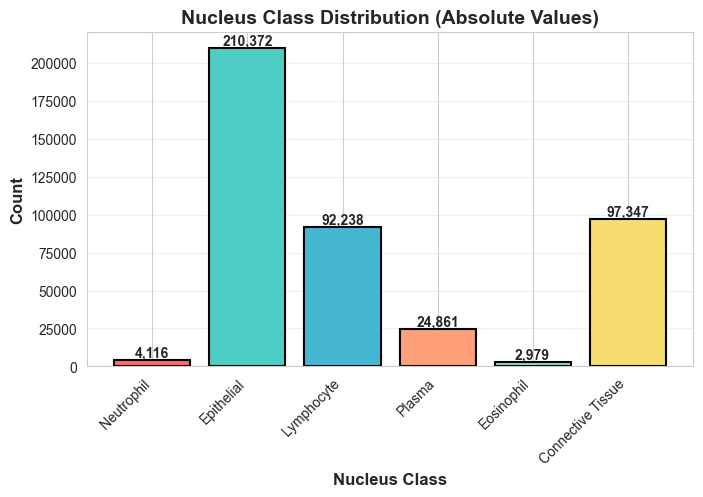

In [63]:
class_names_list = [CLASS_NAMES[i] for i in sorted(global_class_counts.keys())]
class_counts_list = [global_class_counts[i] for i in sorted(global_class_counts.keys())]
colors_list = [CLASS_COLORS[i] for i in sorted(global_class_counts.keys())]

fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

ax1 = fig.add_subplot(gs[0, 0])
bars = ax1.bar(class_names_list, class_counts_list, color=colors_list, edgecolor='black', linewidth=1.5)
ax1.set_xlabel('Nucleus Class', fontsize=12, fontweight='bold')
ax1.set_ylabel('Count', fontsize=12, fontweight='bold')
ax1.set_title('Nucleus Class Distribution (Absolute Values)', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
ax1.set_xticklabels(class_names_list, rotation=45, ha='right')

for bar, count in zip(bars, class_counts_list):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(count):,}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

total_nuclei = sum(class_counts_list)
print("\nDetailed class statistics:")
for class_id in sorted(global_class_counts.keys()):
    count = global_class_counts[class_id]
    percentage = (count / total_nuclei) * 100
    print(f"{CLASS_NAMES[class_id]:20s}: {count:6,} ({percentage:5.2f}%)")
print(f"{'TOTAL':20s}: {total_nuclei:6,}")


### Analysis of core sizes

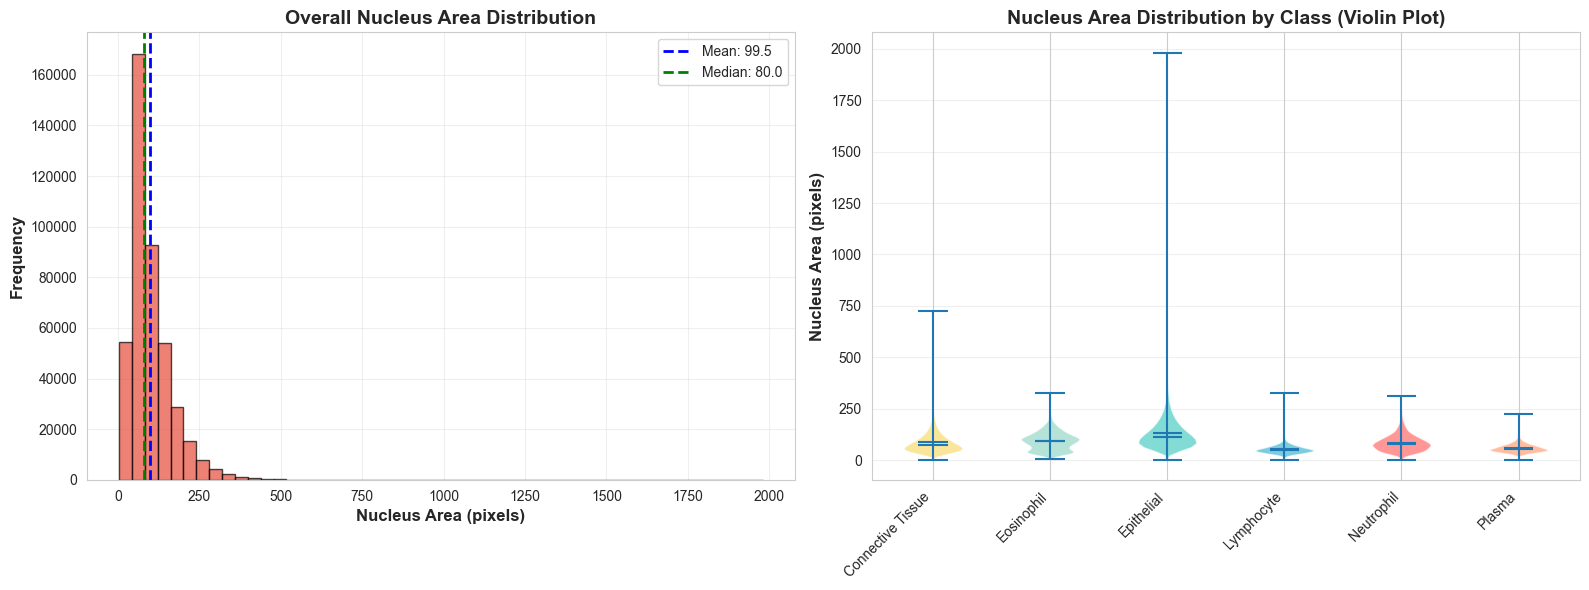


Nucleus Area Statistics:
Overall Mean: 99.52 pixels
Overall Median: 80.00 pixels
Overall Std Dev: 66.75 pixels
Min: 3.00 pixels
Max: 1981.00 pixels

By Class:
Connective Tissue   : Mean=   87.1, Median=   75.0, Std=   51.2
Eosinophil          : Mean=   94.8, Median=   94.0, Std=   45.4
Epithelial          : Mean=  130.8, Median=  115.0, Std=   74.0
Lymphocyte          : Mean=   52.8, Median=   51.0, Std=   18.2
Neutrophil          : Mean=   86.1, Median=   80.0, Std=   41.5
Plasma              : Mean=   59.4, Median=   56.0, Std=   21.0


In [64]:
stats_rows_for_plot = []
for stats in all_stats:
    for class_id, area in zip(stats['classes'], stats['areas']):
        stats_rows_for_plot.append({
            'area': area,
            'class_id': class_id,
            'class_name': CLASS_NAMES[class_id]
        })

stats_df = pd.DataFrame(stats_rows_for_plot)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].hist(stats_df['area'], bins=50, edgecolor='black', color='#e74c3c', alpha=0.7)
axes[0].axvline(stats_df['area'].mean(), color='blue', linestyle='--', linewidth=2,
                   label=f'Mean: {stats_df["area"].mean():.1f}')
axes[0].axvline(stats_df['area'].median(), color='green', linestyle='--', linewidth=2,
                   label=f'Median: {stats_df["area"].median():.1f}')
axes[0].set_xlabel('Nucleus Area (pixels)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Overall Nucleus Area Distribution', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

class_order = sorted(stats_df['class_name'].unique())

parts = axes[1].violinplot([stats_df[stats_df['class_name'] == cls]['area'] for cls in class_order],
                              positions=range(len(class_order)),
                              showmeans=True,
                              showmedians=True)

for i, pc in enumerate(parts['bodies']):
    cls = class_order[i]
    class_id = list(CLASS_NAMES.keys())[list(CLASS_NAMES.values()).index(cls)]
    pc.set_facecolor(CLASS_COLORS.get(class_id, '#999999'))
    pc.set_alpha(0.7)

axes[1].set_xticks(range(len(class_order)))
axes[1].set_xticklabels(class_order, rotation=45, ha='right')
axes[1].set_ylabel('Nucleus Area (pixels)', fontsize=12, fontweight='bold')
axes[1].set_title('Nucleus Area Distribution by Class (Violin Plot)', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nNucleus Area Statistics:")
print(f"Overall Mean: {stats_df['area'].mean():.2f} pixels")
print(f"Overall Median: {stats_df['area'].median():.2f} pixels")
print(f"Overall Std Dev: {stats_df['area'].std():.2f} pixels")
print(f"Min: {stats_df['area'].min():.2f} pixels")
print(f"Max: {stats_df['area'].max():.2f} pixels")
print("\nBy Class:")

for cls in class_order:
    class_data = stats_df[stats_df['class_name'] == cls]['area']
    print(f"{cls:20s}: Mean={class_data.mean():7.1f}, Median={class_data.median():7.1f}, Std={class_data.std():7.1f}")

### Analysis of the number of nuclei per image

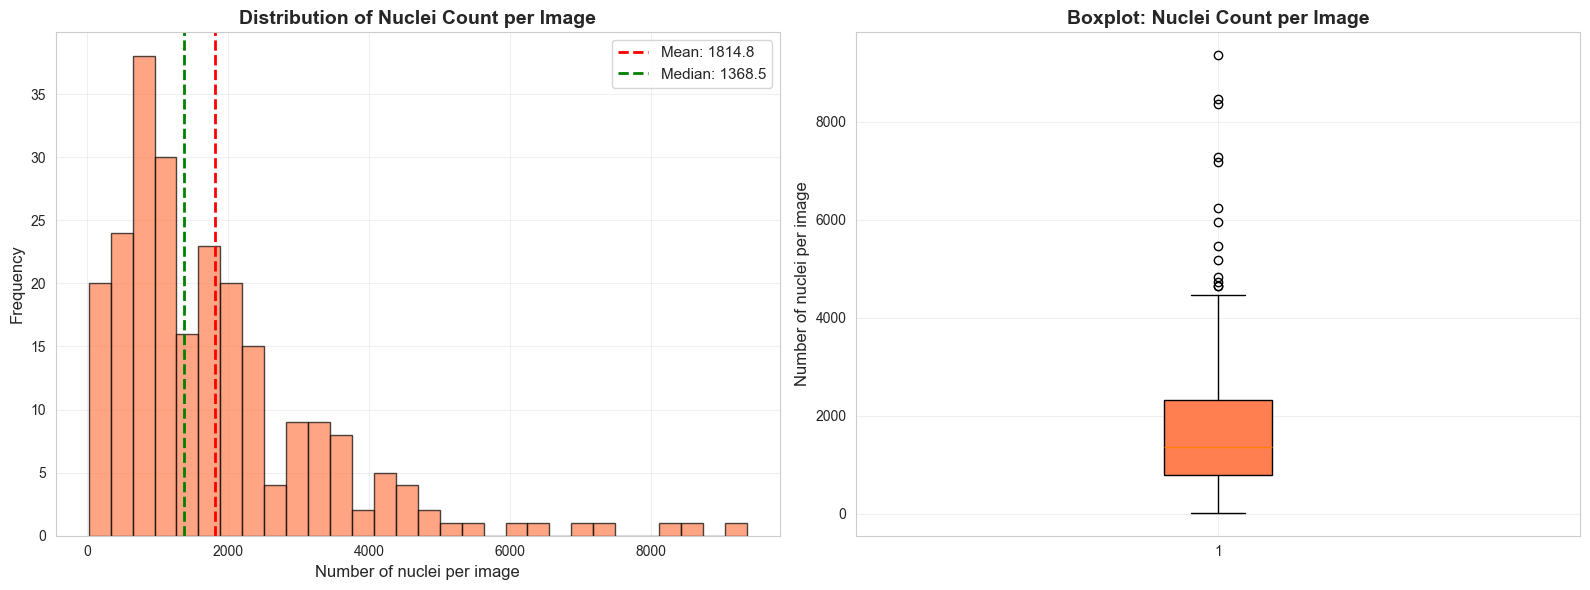


Statistics for nuclei count per image:
Mean: 1814.76
Median: 1368.50
Standard deviation: 1547.54
Minimum: 17
Maximum: 9354
25th percentile: 789.50
75th percentile: 2321.75


In [65]:
nuclei_per_image = [stat['total_nuclei'] for stat in all_stats]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].hist(nuclei_per_image, bins=30, color='coral', edgecolor='black', alpha=0.7)
axes[0].axvline(np.mean(nuclei_per_image), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {np.mean(nuclei_per_image):.1f}')
axes[0].axvline(np.median(nuclei_per_image), color='green', linestyle='--', linewidth=2,
                label=f'Median: {np.median(nuclei_per_image):.1f}')
axes[0].set_xlabel('Number of nuclei per image', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Nuclei Count per Image', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

bp = axes[1].boxplot(nuclei_per_image, vert=True, patch_artist=True)
bp['boxes'][0].set_facecolor('coral')
axes[1].set_ylabel('Number of nuclei per image', fontsize=12)
axes[1].set_title('Boxplot: Nuclei Count per Image', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nStatistics for nuclei count per image:")
print(f"Mean: {np.mean(nuclei_per_image):.2f}")
print(f"Median: {np.median(nuclei_per_image):.2f}")
print(f"Standard deviation: {np.std(nuclei_per_image):.2f}")
print(f"Minimum: {np.min(nuclei_per_image)}")
print(f"Maximum: {np.max(nuclei_per_image)}")
print(f"25th percentile: {np.percentile(nuclei_per_image, 25):.2f}")
print(f"75th percentile: {np.percentile(nuclei_per_image, 75):.2f}")


### Visualisation of image examples

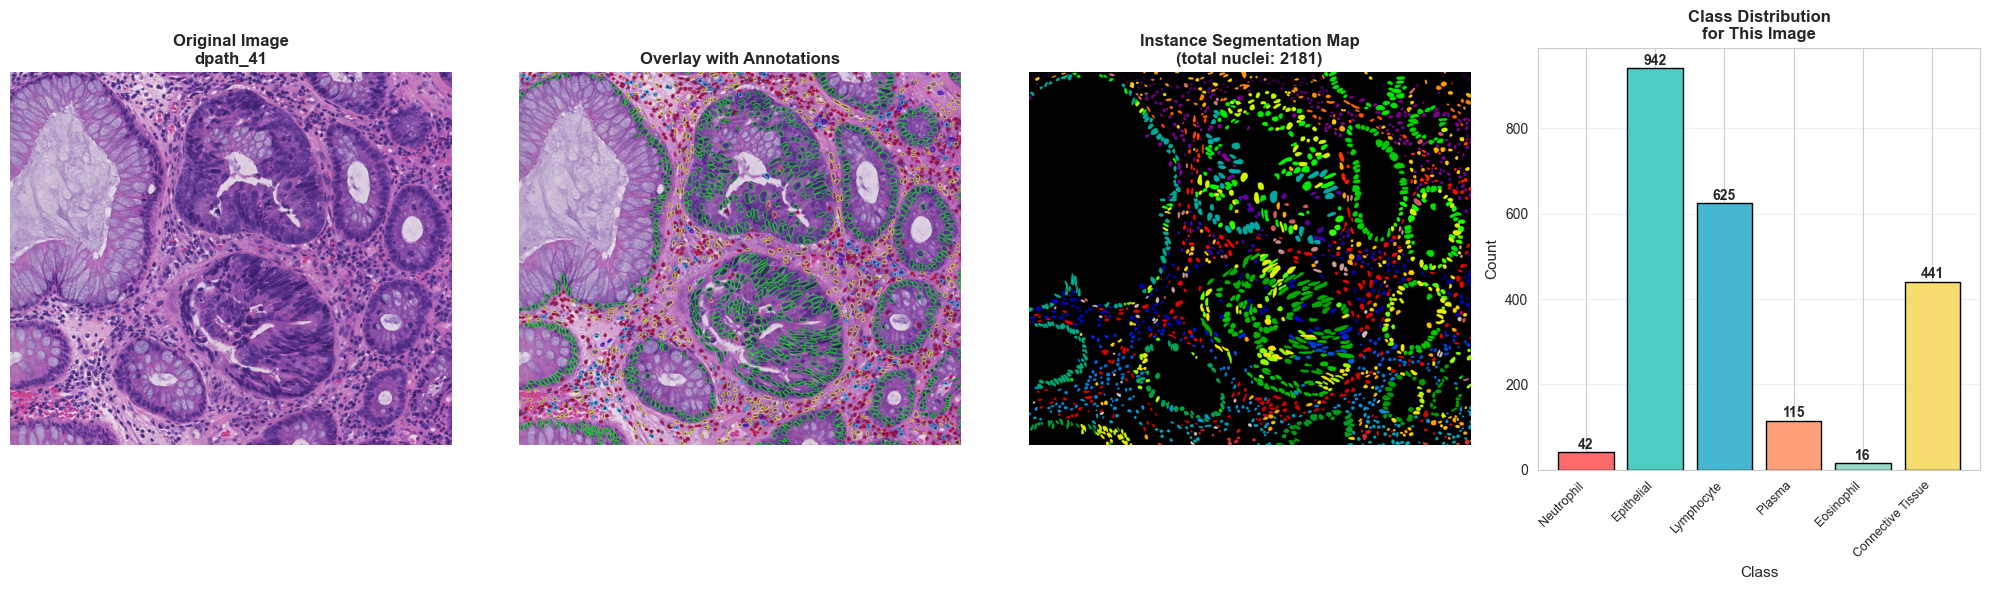

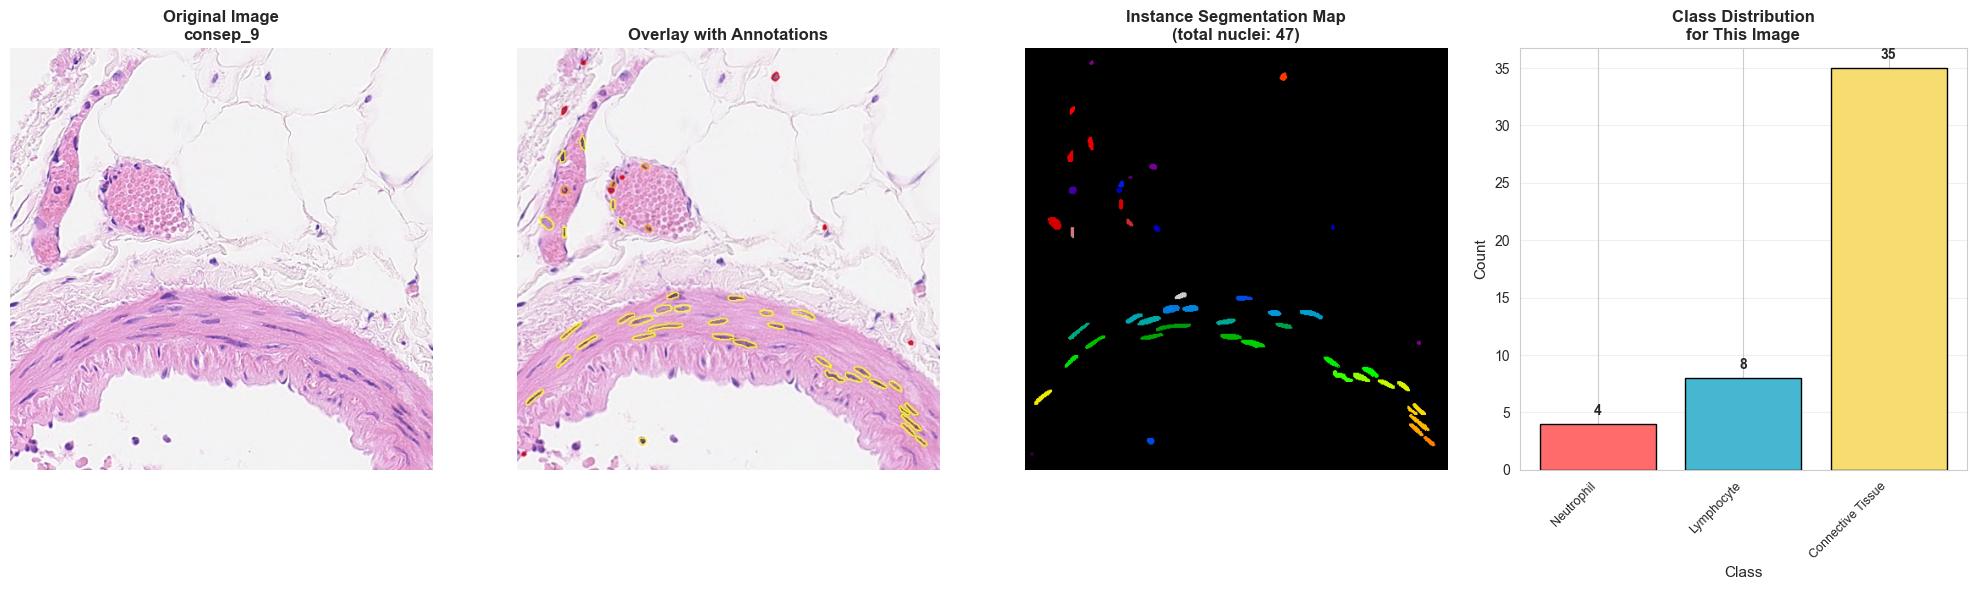

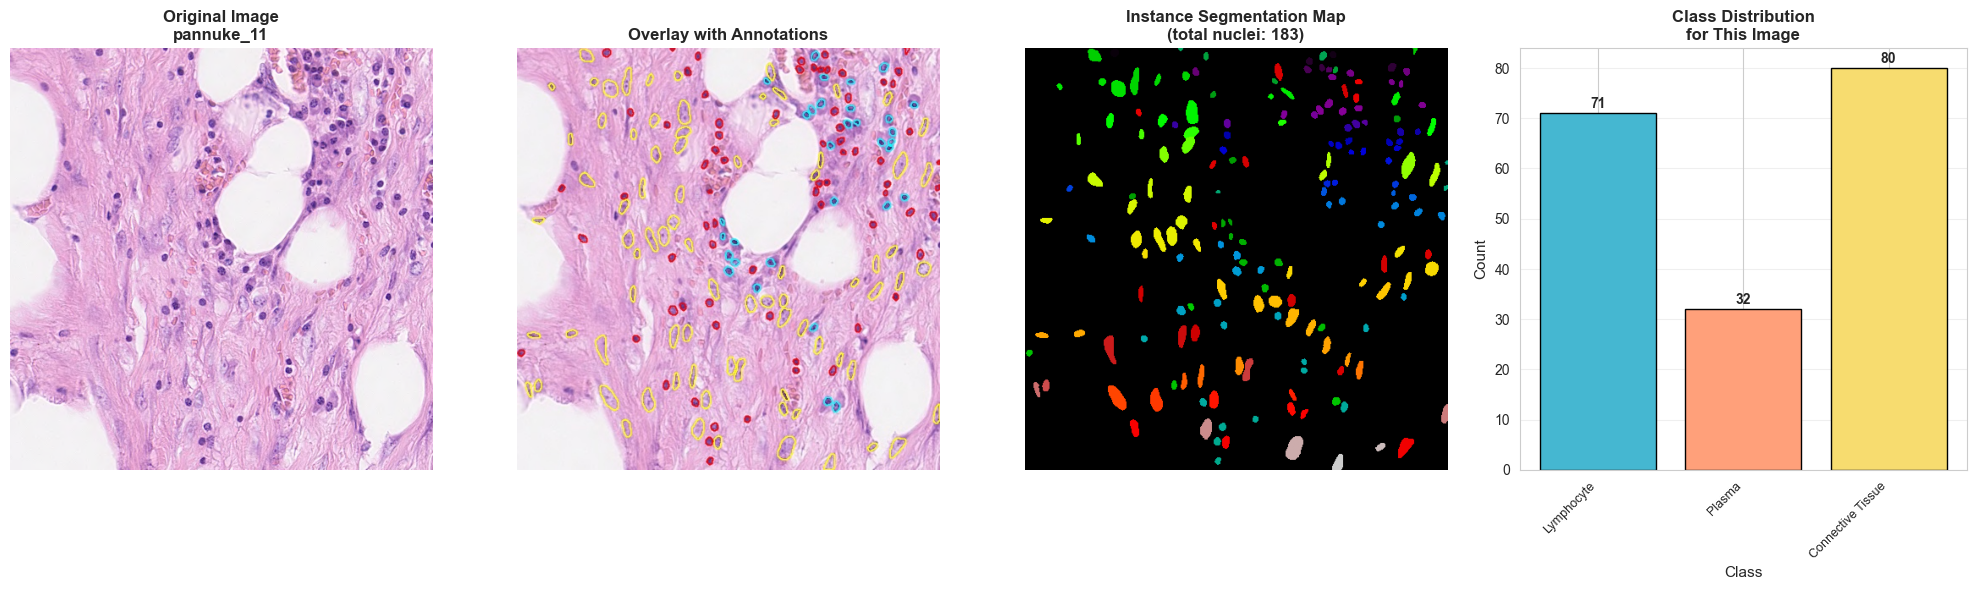

In [66]:
def visualize_sample(filename, images_path_1, images_path_2, labels_path, overlay_path):

    img_name = f"{filename}.png"
    img = load_image(img_name, images_path_1, images_path_2)

    overlay_name = f"{filename}.jpg"
    overlay_path_full = os.path.join(overlay_path, overlay_name)
    overlay = np.array(Image.open(overlay_path_full)) if os.path.exists(overlay_path_full) else None

    label_name = f"{filename}.mat"
    label_path_full = os.path.join(labels_path, label_name)
    label_data = load_label(label_path_full)

    if img is None or label_data is None:
        print(f"Failed to load data for {filename}")
        return

    stats = get_nuclei_stats(label_data)

    fig = plt.figure(figsize=(20, 6))

    ax1 = plt.subplot(1, 4, 1)
    ax1.imshow(img)
    ax1.set_title(f'Original Image\n{filename}', fontsize=12, fontweight='bold')
    ax1.axis('off')

    # Overlay
    if overlay is not None:
        ax2 = plt.subplot(1, 4, 2)
        ax2.imshow(overlay)
        ax2.set_title('Overlay with Annotations', fontsize=12, fontweight='bold')
        ax2.axis('off')

    ax3 = plt.subplot(1, 4, 3)
    inst_map = label_data['inst_map']
    ax3.imshow(inst_map, cmap='nipy_spectral')
    ax3.set_title(f'Instance Segmentation Map\n(total nuclei: {stats["total_nuclei"]})',
                  fontsize=12, fontweight='bold')
    ax3.axis('off')

    ax4 = plt.subplot(1, 4, 4)
    class_counts = stats['class_counts']
    classes = sorted(class_counts.keys())
    counts = [class_counts[c] for c in classes]
    colors = [CLASS_COLORS[c] for c in classes]
    labels = [CLASS_NAMES[c] for c in classes]

    ax4.bar(labels, counts, color=colors, edgecolor='black')
    ax4.set_xlabel('Class', fontsize=11)
    ax4.set_ylabel('Count', fontsize=11)
    ax4.set_title('Class Distribution\nfor This Image', fontsize=12, fontweight='bold')
    ax4.set_xticklabels(labels, rotation=45, ha='right', fontsize=9)
    ax4.grid(axis='y', alpha=0.3)

    for i, (label, count) in enumerate(zip(labels, counts)):
        ax4.text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.show()

np.random.seed(42)
sample_filenames = [stat['filename'] for stat in np.random.choice(all_stats, 3, replace=False)]

for filename in sample_filenames:
    visualize_sample(filename, IMAGES_PATH_1, IMAGES_PATH_2, LABELS_PATH, OVERLAY_PATH)

### Analysis of class ratios in individual images

In [67]:
class_distribution_matrix = []
image_names = []

for stat in all_stats:
    image_names.append(stat['filename'])
    row = []
    for class_id in sorted(CLASS_NAMES.keys()):
        count = stat['class_counts'].get(class_id, 0)
        row.append(count)
    class_distribution_matrix.append(row)

class_distribution_matrix = np.array(class_distribution_matrix)

row_sums = class_distribution_matrix.sum(axis=1, keepdims=True)
normalized_matrix = (class_distribution_matrix / row_sums) * 100

print("\nVariability of class distribution across images:")
for i, class_name in enumerate(class_names_list):
    percentages = normalized_matrix[:, i]
    print(f"{class_name:20s}: Mean {np.mean(percentages):5.2f}%, std: {np.std(percentages):5.2f} (min: {np.min(percentages):5.2f}%, max: {np.max(percentages):5.2f}%)")



Variability of class distribution across images:
Neutrophil          : Mean  1.02%, std:  2.91 (min:  0.00%, max: 26.67%)
Epithelial          : Mean 50.50%, std: 24.01 (min:  0.00%, max: 95.40%)
Lymphocyte          : Mean 18.41%, std: 14.44 (min:  0.84%, max: 90.85%)
Plasma              : Mean  5.59%, std:  6.62 (min:  0.00%, max: 52.06%)
Eosinophil          : Mean  0.57%, std:  0.96 (min:  0.00%, max:  9.73%)
Connective Tissue   : Mean 23.91%, std: 15.51 (min:  0.10%, max: 94.18%)


### Correlation between classes

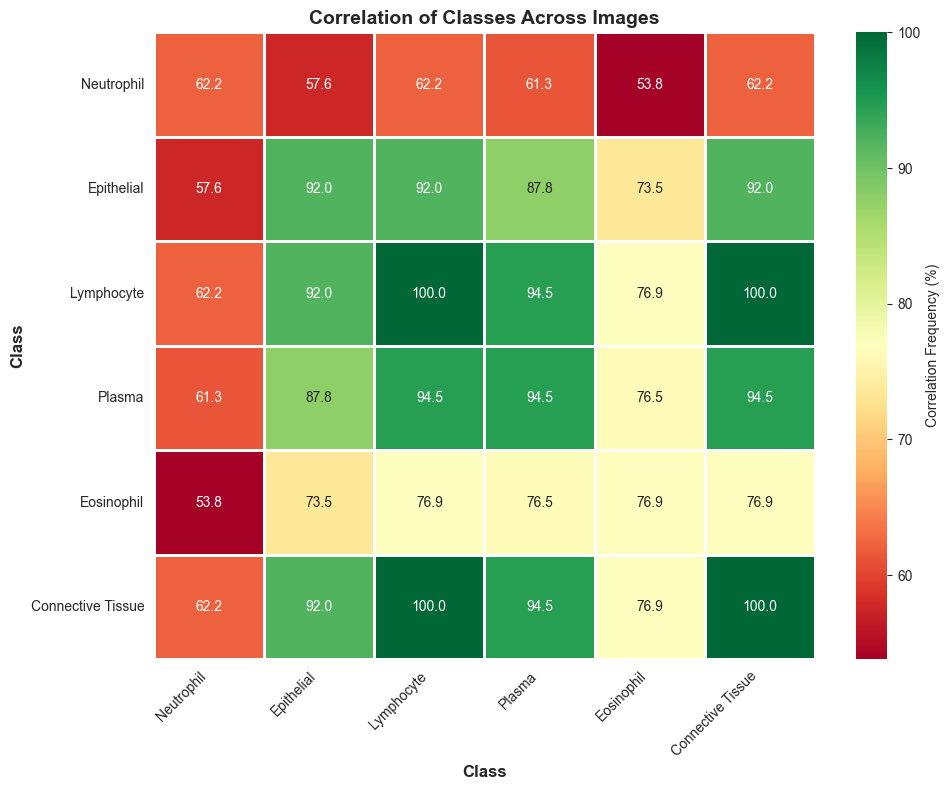

In [68]:
correlation_matrix = np.zeros((len(CLASS_NAMES), len(CLASS_NAMES)))

for stat in all_stats:
    classes_present = list(stat['class_counts'].keys())
    for i, class1 in enumerate(sorted(CLASS_NAMES.keys())):
        for j, class2 in enumerate(sorted(CLASS_NAMES.keys())):
            if class1 in classes_present and class2 in classes_present:
                correlation_matrix[i, j] += 1

correlation_matrix = correlation_matrix / len(all_stats) * 100

plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    xticklabels=class_names_list,
    yticklabels=class_names_list,
    annot=True,
    fmt='.1f',
    cmap='RdYlGn',
    cbar_kws={'label': 'Correlation Frequency (%)'},
    linewidths=1,
    linecolor='white'
)
plt.xlabel('Class', fontsize=12, fontweight='bold')
plt.ylabel('Class', fontsize=12, fontweight='bold')
plt.title('Correlation of Classes Across Images', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### Image Dimensions Analysis

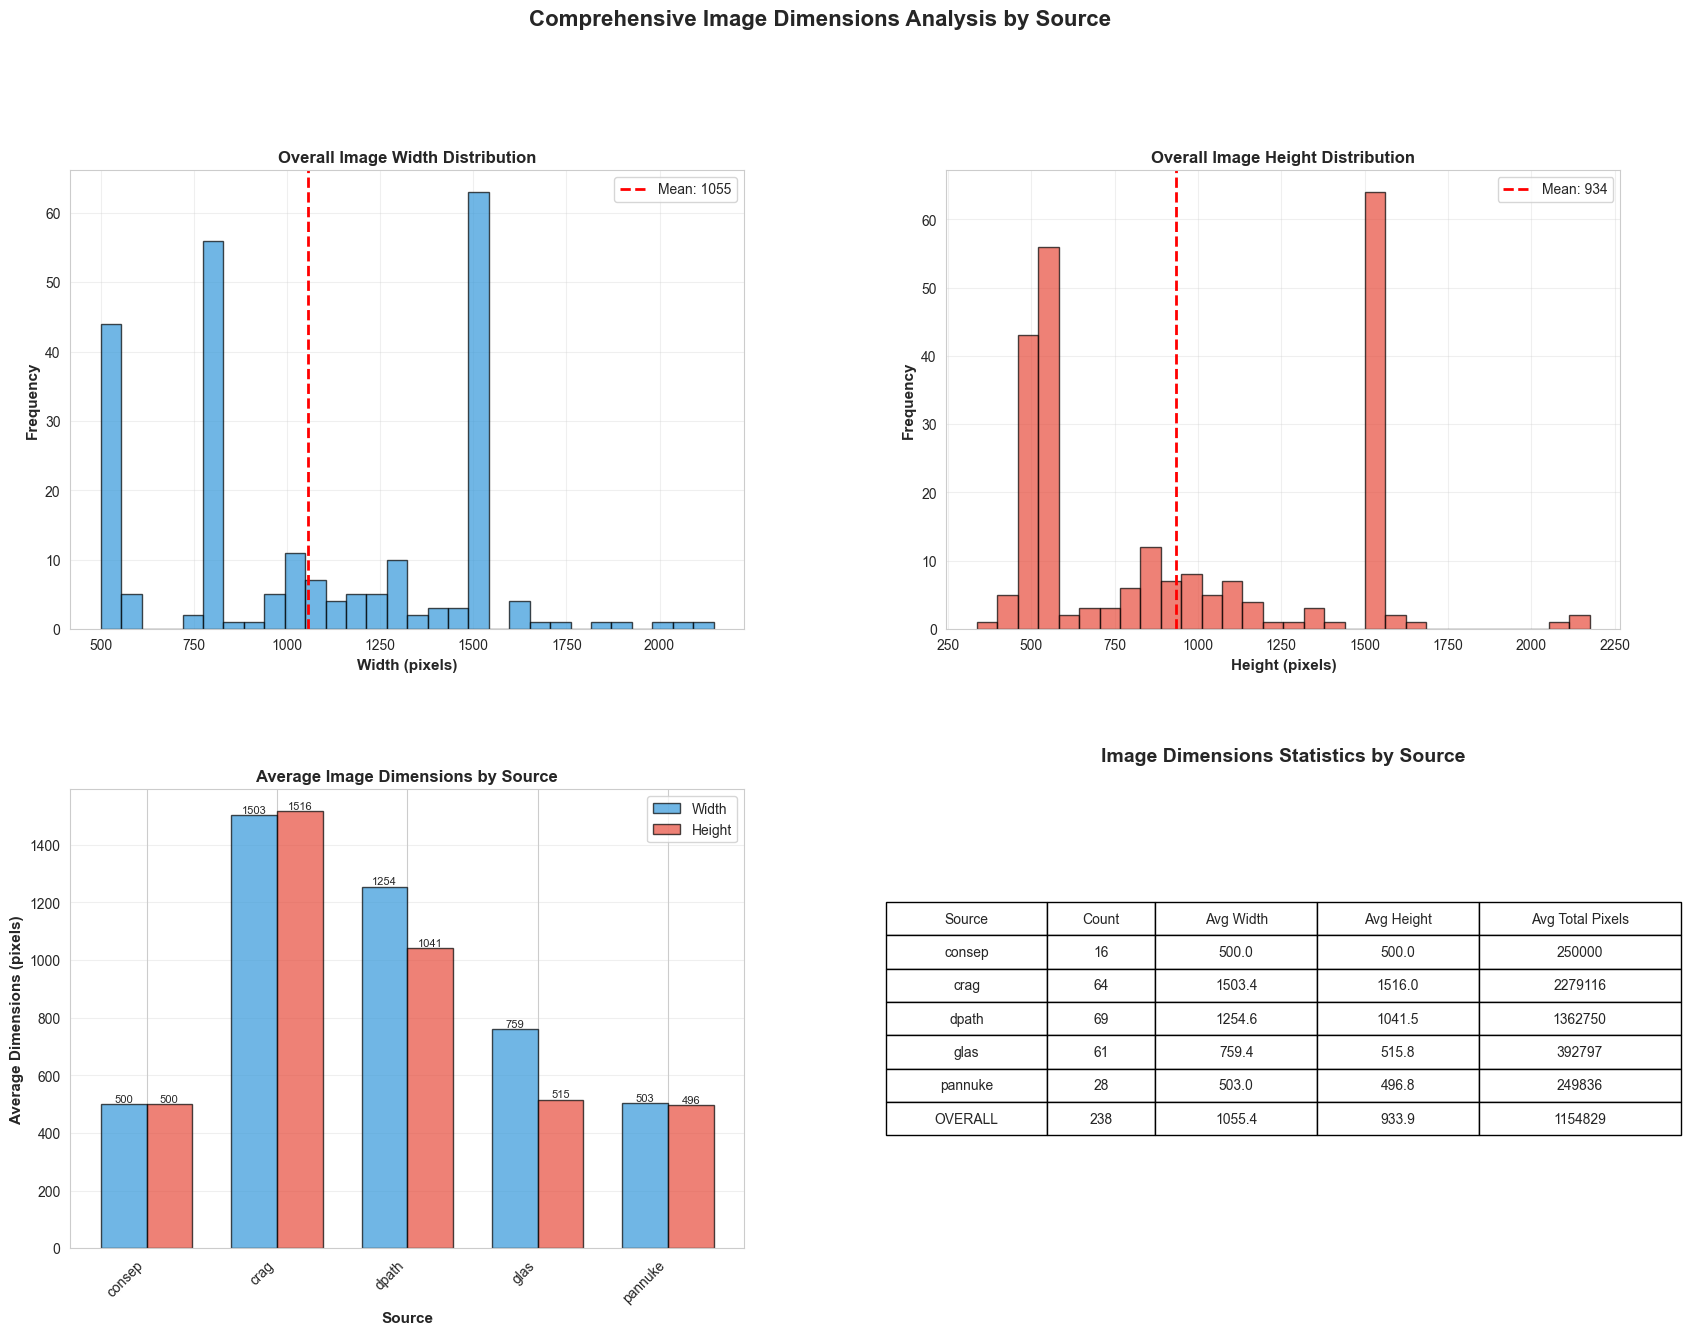

Source: consep
Number of images: 16
Dimensions:
Width:  500.0 ± 0.0 pixels
Height: 500.0 ± 0.0 pixels
Unique image sizes: 1
All images have same dimensions: 500 x 500


Source: crag
Number of images: 64
Dimensions:
Width:  1503.4 ± 33.6 pixels
Height: 1516.0 ± 0.0 pixels
Unique image sizes: 8
Most common size: 1511x1516 (appears 22 times)


Source: dpath
Number of images: 69
Dimensions:
Width:  1254.6 ± 298.3 pixels
Height: 1041.5 ± 321.7 pixels
Unique image sizes: 69
Most common size: 738x760 (appears 1 times)


Source: glas
Number of images: 61
Dimensions:
Width:  759.4 ± 52.7 pixels
Height: 515.8 ± 20.9 pixels
Unique image sizes: 4
Most common size: 775x522 (appears 56 times)


Source: pannuke
Number of images: 28
Dimensions:
Width:  503.0 ± 5.3 pixels
Height: 496.8 ± 31.7 pixels
Unique image sizes: 3
Most common size: 500x500 (appears 21 times)




In [69]:
image_dimensions = []
for stat in all_stats:
    filename = stat['filename']
    img_name = f"{filename}.png"

    source_prefix = filename.split('_')[0]

    img = load_image(img_name, IMAGES_PATH_1, IMAGES_PATH_2)

    if img is not None:
        height, width = img.shape[:2]
        image_dimensions.append({
            'filename': filename,
            'source': source_prefix,
            'width': width,
            'height': height,
            'total_pixels': width * height
        })

img_dims_df = pd.DataFrame(image_dimensions)

fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(2, 2, hspace=0.35, wspace=0.3)

ax1 = fig.add_subplot(gs[0, 0])
ax1.hist(img_dims_df['width'], bins=30, color='#3498db', edgecolor='black', alpha=0.7)
ax1.axvline(img_dims_df['width'].mean(), color='red', linestyle='--', linewidth=2,
            label=f'Mean: {img_dims_df["width"].mean():.0f}')
ax1.set_xlabel('Width (pixels)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax1.set_title('Overall Image Width Distribution', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

ax2 = fig.add_subplot(gs[0, 1])
ax2.hist(img_dims_df['height'], bins=30, color='#e74c3c', edgecolor='black', alpha=0.7)
ax2.axvline(img_dims_df['height'].mean(), color='red', linestyle='--', linewidth=2,
            label=f'Mean: {img_dims_df["height"].mean():.0f}')
ax2.set_xlabel('Height (pixels)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax2.set_title('Overall Image Height Distribution', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

sources = sorted(img_dims_df['source'].unique())
source_colors = sns.color_palette("husl", len(sources))

ax3 = fig.add_subplot(gs[1, 0])
avg_dims_by_source = img_dims_df.groupby('source')[['width', 'height']].mean()
x_pos = np.arange(len(sources))
width_bar = 0.35
bars1 = ax3.bar(x_pos - width_bar/2, avg_dims_by_source['width'], width_bar,
                label='Width', color='#3498db', alpha=0.7, edgecolor='black')
bars2 = ax3.bar(x_pos + width_bar/2, avg_dims_by_source['height'], width_bar,
                label='Height', color='#e74c3c', alpha=0.7, edgecolor='black')
ax3.set_xlabel('Source', fontsize=11, fontweight='bold')
ax3.set_ylabel('Average Dimensions (pixels)', fontsize=11, fontweight='bold')
ax3.set_title('Average Image Dimensions by Source', fontsize=12, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(sources, rotation=45, ha='right')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                 f'{int(height)}', ha='center', va='bottom', fontsize=8)

ax4 = fig.add_subplot(gs[1, 1])
ax4.axis('tight')
ax4.axis('off')

table_data = [['Source', 'Count', 'Avg Width', 'Avg Height', 'Avg Total Pixels']]
for source in sources:
    source_data = img_dims_df[img_dims_df['source'] == source]
    table_data.append([
        source,
        f"{len(source_data)}",
        f"{source_data['width'].mean():.1f}",
        f"{source_data['height'].mean():.1f}",
        f"{source_data['total_pixels'].mean():.0f}"
    ])

table_data.append([
    'OVERALL',
    f"{len(img_dims_df)}",
    f"{img_dims_df['width'].mean():.1f}",
    f"{img_dims_df['height'].mean():.1f}",
    f"{img_dims_df['total_pixels'].mean():.0f}"
])

table = ax4.table(cellText=table_data, cellLoc='center', loc='center',
                   colWidths=[0.12, 0.08, 0.12, 0.12, 0.15])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(2, 2)

ax4.set_title('Image Dimensions Statistics by Source', fontsize=14, fontweight='bold', pad=20)

plt.suptitle('Comprehensive Image Dimensions Analysis by Source', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


for source in sources:
    source_data = img_dims_df[img_dims_df['source'] == source]
    print(f"Source: {source}")
    print(f"Number of images: {len(source_data)}")
    print(f"Dimensions:")
    print(f"Width:  {source_data['width'].mean():.1f} ± {source_data['width'].std():.1f} pixels")
    print(f"Height: {source_data['height'].mean():.1f} ± {source_data['height'].std():.1f} pixels")

    unique_sizes = source_data.groupby(['width', 'height']).size()
    print(f"Unique image sizes: {len(unique_sizes)}")
    if len(unique_sizes) == 1:
        print(f"All images have same dimensions: {source_data['width'].iloc[0]:.0f} x {source_data['height'].iloc[0]:.0f}")
    else:
        most_common_size = unique_sizes.idxmax()
        print(f"Most common size: {most_common_size[0]}x{most_common_size[1]} (appears {unique_sizes.max()} times)")
    print(f"\n")

all_same = True
first_dims = None
for source in sources:
    source_data = img_dims_df[img_dims_df['source'] == source]
    unique_sizes = source_data.groupby(['width', 'height']).size()
    if len(unique_sizes) > 1:
        all_same = False
        break
    if first_dims is None:
        first_dims = unique_sizes.index[0]
    elif first_dims != unique_sizes.index[0]:
        all_same = False
        break